In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import re, pip, conda
import time
import os

## 2 XGBoost回归的sklearnAPI实现

不同于内嵌在sklearn框架中的其他算法，xgboost是独立的算法库，因此它有一套不同于sklearn代码的原生代码。大部分时候我们使用原生代码来运行xgboost，因为这套原生代码是完全为集成学习所设计的，不仅可以无缝使用交叉验证、默认输出指标为RMSE，还能够默认输出训练集上的结果帮我们监控模型。然而对于熟悉sklearn的我们来说，这一套代码略有难度，因此许多人也会倾向于使用xgboost自带的sklearn接口来实现算法。

XGBoost自带sklearn接口（sklearn API），通过这个接口，我们可以使用跟sklearn代码一样的方式来实现xgboost，即可以通过fit和predict等接口来执行训练预测过程，也可以调用属性比如coef_等。在XGBoost的sklearn API中，我们可以看到下面五个类：

|类|说明|
|:-:|:-:|
|**XGBRegressor()**|实现xgboost回归|
|**XGBClassifier()**|实现xgboost分类|
|**XGBRanker()**|实现xgboost排序|
|**XGBRFClassifier()**|基于xgboost库实现随机森林分类|
|**XGBRFRegressor()**|基于xgboost库实现随机森林回归|

其中XGBRF的两个类是以XGBoost方式建树、但以bagging方式构建森林的类，通常只有在我们使用普通随机森林效果不佳、但又不希望使用Boosting的时候使用。这种使用XGBoost方式建树的森林在sklearn中已经开始了实验，不过还没有正式上线。

另外两个类就很容易理解了，一个是XGBoost的回归，一个是XGBoost的分类。这两个类的参数高度相似，我们可以以XGBoost回归为例查看：

*class* `xgboost.XGBRegressor`(n_estimators, max_depth, learning_rate, verbosity, objective, booster, tree_method, n_jobs, gamma, min_child_weight, max_delta_step, subsample, colsample_bytree, colsample_bylevel, colsample_bynode, reg_alpha, reg_lambda, scale_pos_weight, base_score, random_state, missing, num_parallel_tree, monotone_constraints, interaction_constraints, importance_type, gpu_id, validate_parameters, predictor, enable_categorical, eval_metric, early_stopping_rounds, callbacks,**kwargs)

*class* `xgboost.XGBClassifier`(n_estimators, use_label_encoder, max_depth, learning_rate, verbosity, objective, booster, tree_method, n_jobs, gamma, min_child_weight, max_delta_step, subsample, colsample_bytree, colsample_bylevel, colsample_bynode, reg_alpha, reg_lambda, scale_pos_weight, base_score, random_state, missing, num_parallel_tree, monotone_constraints, interaction_constraints, importance_type, gpu_id, validate_parameters, predictor, enable_categorical, **kwargs)

可以看到，两个类的参数两都很多，其中不乏一些我们非常熟悉的参数，例如`n_estimators`，`learning_rate`, `max_depth`等。但大部分参数还是需要我们重新学习和认识，这与xgboost复杂的原理有很大的关系，但由于是sklearn API，所以所有这些参数都有相应的默认值。我们可以在不认识参数的情况下调用这个类。以回归类为例我们来看：

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv(r"D:\myJupyter\机器学习#回归数据
X = data.iloc[:,:-1]
y = data.iloc[:,-1]\datasets\House Price\train_encode.csv",index_col=0)

In [ ]:
X.shape

(1460, 80)

In [ ]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

在这个数据集上我们曾经达到过如下的分数：

|算法|RF|AdaBoost|GBDT|RF<br>(TPE)|AdaBoost<br>(TPE)|GBDT<br>(TPE)|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|5折验证<br>运行时间|1.29s|0.28s|0.49s|0.22s|0.27s|<font color="brown">**1.54s(↑)**</font>|
|测试最优分数<br>(RMSE)|30571.267|35345.931|28783.954|28346.673|35169.730|<font color="green">**26415.835(↓)**</font>|

In [ ]:
#sklearn普通训练代码三步走：实例化，fit，score

Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3,random_state=1412)

xgb_sk = XGBRegressor(random_state=1412) #实例化模型
xgb_sk.fit(Xtrain,Ytrain)
xgb_sk.score(Xtest,Ytest) #默认指标R2

0.8707175563742298

In [ ]:
#sklearn交叉验证三步走：实例化，交叉验证，对结果求平均

xgb_sk = XGBRegressor(random_state=1412) #实例化模型

In [ ]:
#定义所需的交叉验证方式
cv = KFold(n_splits=5,shuffle=True,random_state=1412)

result_xgb_sk = cross_validate(xgb_sk,X,y,cv=cv
                               ,scoring="neg_root_mean_squared_error" #负根均方误差
                               ,return_train_score=True
                               ,verbose=True
                               ,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


In [ ]:
result_xgb_sk

{'fit_time': array([0.23205304, 0.45810175, 0.46110272, 0.47810745, 0.47210622]),
 'score_time': array([0.00499988, 0.00500083, 0.00700212, 0.00600123, 0.0080018 ]),
 'test_score': array([-25398.06063039, -42892.11176772, -26426.91326917, -20676.41934632,
        -33375.56869975]),
 'train_score': array([ -903.74997856, -1106.45801425,  -997.3799282 ,  -818.69215194,
         -877.57892862])}

In [ ]:
def RMSE(result,name):
    return abs(result[name].mean())

In [ ]:
RMSE(result_xgb_sk,"train_score")

940.7718003131752

In [ ]:
RMSE(result_xgb_sk,"test_score")

29753.814742669765

可以看到，在默认参数下，xgboost模型极度不稳定，并且过拟合的情况非常严重，在训练集上的RMSE达到了前所未有的低点940.77，这说明XGBoost的学习能力的确强劲，现有数据量对xgboost来说可能有点不足。在没有调整任何参数的情况下，XGBoost的表现没能胜过梯度提升树，这可能是因为在默认参数下梯度提升树的过拟合程度较轻。我们可以尝试使用之前学过的知识，对XGBoost的参数略微进行调整，例如将最可能影响模型的参数之一：`max_depth`设置为一个较小的值。

In [ ]:
xgb_sk = XGBRegressor(max_depth=5,random_state=1412) #实例化

In [ ]:
result_xgb_sk = cross_validate(xgb_sk,X,y,cv=cv
                               ,scoring="neg_root_mean_squared_error" #负根均方误差
                               ,return_train_score=True
                               ,verbose=True
                               ,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


In [ ]:
RMSE(result_xgb_sk,"train_score")

2362.6596931022264

In [ ]:
RMSE(result_xgb_sk,"test_score")

28623.2199609373

过拟合程度立刻减轻了，这说明模型是有潜力的，经过精密的调参之后xgboost上应该能够获得不错的结果。

当sklearn API训练完毕之后，我们可以调用sklearn中常见的部分属性对训练后的模型进行查看，例如查看特征重要性的属性`feature_importances_`，以及查看XGB下每一棵树的`get_booster()`方法、查看总共有多少棵树的`get_num_boosting_rounds()`方法、以及查看当前所有参数的方法`get_params`。

In [ ]:
xgb_sk = XGBRegressor(max_depth=5,random_state=1412).fit(X,y)

In [ ]:
#查看特征重要性
xgb_sk.feature_importances_

array([2.75380560e-04, 3.31971998e-04, 1.00358156e-02, 1.05883693e-03,
       3.16664134e-03, 0.00000000e+00, 1.98506648e-04, 2.89293937e-03,
       1.25273280e-02, 0.00000000e+00, 5.93377743e-04, 1.02778999e-02,
       2.30982271e-03, 1.63636741e-03, 2.90878420e-03, 2.35304120e-03,
       6.21278654e-04, 4.83804524e-01, 3.57081974e-03, 5.26868505e-03,
       5.39273489e-03, 1.19193934e-03, 6.73988950e-04, 8.58596177e-04,
       7.24220707e-04, 6.31435658e-04, 6.40772341e-04, 1.79228242e-02,
       1.88877675e-04, 5.03550633e-04, 1.56989340e-02, 2.03612563e-03,
       2.47432292e-03, 1.01661379e-03, 8.10322072e-03, 2.90135911e-04,
       5.88890282e-04, 7.41500990e-04, 1.55724427e-02, 4.79830429e-04,
       3.00964224e-04, 3.08048874e-02, 1.71841952e-04, 1.05094137e-02,
       7.64262909e-03, 5.08715457e-04, 3.02572548e-02, 2.92710634e-03,
       3.74272262e-04, 3.38621549e-02, 1.68845232e-03, 5.42165304e-04,
       3.92313190e-02, 2.88939234e-02, 3.41931777e-03, 3.12080747e-03,
      

In [ ]:
#调出其中一棵树，不过无法展示出树的细节，只能够调出建树的Booster对象
xgb_sk.get_booster()[2]

一棵树都是一个单独的Booster提升树，Booster就相当于sklearn中DecisionTreeRegressor，只不过是使用xgboost独有的建树规则进行计算。

In [ ]:
#查看一共建立了多少棵树，相当于是n_estimators的取值
xgb_sk.get_num_boosting_rounds()

100

In [ ]:
#获取每一个参数的取值
xgb_sk.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 16,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 1412,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

查看参数对xgboost来说很有意义，因为XGBRegressor的说明中没有注明默认参数，因此通过查看参数，我们可以了解到xgboost在sklearn API中都设置了怎样的参数，作为未来调参的参考。对于xgboost分类器，我们还可以调用`predict_proba`这样的方法来输出概率值，除此之外我们一般不会再用到xgboost sklearn API中的其他功能。

## 3 XGBoost回归的原生代码实现

XGBoost的原生代码与我们已经习惯了的sklearn代码有很大的不同。首先，**原生代码必须使用XGBoost自定义的数据结构DMatrix**，这一数据结构能够保证xgboost算法运行更快，并且能够自然迁移到GPU上运行，类似于列表、数组、Dataframe等结构都不能用于原生代码，因此使用原生代码的第一步就是要更换数据结构。

![](http://pictes.oss-cn-beijing.aliyuncs.com/%E5%BE%AE%E8%AF%BE%20-%20sklearn/week%2011%20XGBoost/xgb%E5%BB%BA%E6%A8%A1%E6%B5%81%E7%A8%8B.PNG)

当设置好数据结构后，**我们需要以字典形式设置参数**。XGBoost也可以接受像sklearn一样，将所有参数都写在训练所用的类当中，然而由于xgboost的参数列表过长、参数类型过多，直接将所有参数混写在训练模型的类中会显得代码冗长且混乱，因此我们往往会使用字典单独呈现参数。准备好参数列表后，**我们将使用xgboost中自带的方法`xgb.train`或`xgb.cv`进行训练**，训练完毕后，我们可以使用`predict`方法对结果进行预测。虽然xgboost原生代码库所使用的数据结构是DMatrix，但在预测试输出的数据结构却是普通的数组，因此可以直接使用sklearn中的评估指标，或者python编写的评估指标进行评估。接下来，我们来认识一下xgboost原生代码中最关键的方法：

*class* `xgboost.DMatrix`(data, label=None, *, weight=None, base_margin=None, missing=None, silent=False, feature_names=None, feature_types=None, nthread=None, group=None, qid=None, label_lower_bound=None, label_upper_bound=None, feature_weights=None, enable_categorical=False)

*function* `xgboost.train`(*params, dtrain, num_boost_round=10, *, evals=None, obj=None, feval=None, maximize=None, early_stopping_rounds=None, evals_result=None, verbose_eval=True, xgb_model=None, callbacks=None, custom_metric=None)

*function* `xgboost.cv`(*params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(), obj=None, feval=None, maximize=None, early_stopping_rounds=None, fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True, seed=0, callbacks=None, shuffle=True, custom_metric=None)

其中，方法`xgb.train`和`xgb.cv`的第一个参数`params`就是我们需要使用字典自定义的参数列表，第二个参数`dtrain`就是DMatrix结构的训练数据，第三个参数`num_boost_round`其实就等同于sklearn中的`n_estimators`，表示总共建立多少棵提升树，也就是提升过程中的迭代次数。

在之后的课程中，我们将会详细讲解训练中涉及到的每一个参数，在这里我们了解前三个参数就可以。和sklearn中一样，xgboost中的这些参数也都拥有默认值，因此我们可以不填写任何参数就运行xgboost算法。现在，我们来简单看看原生代码是如何实现的：

In [ ]:
import xgboost as xgb

- 将数据转换为DMatrix

XGBoost模块的三步走：将数据转换为DMatrix，定义需要输入的参数params，直接调用训练。第一步，先转换数据格式：

In [ ]:
X.head() #DataFrame

,Id,住宅类型,住宅区域,街道接触面积(英尺),住宅面积,街道路面状况,巷子路面状况,住宅形状(大概),住宅现状,水电气,...,半开放式门廊面积,泳池面积,泳池质量,篱笆质量,其他配置,其他配置的价值,销售月份,销售年份,销售类型,销售状态
0,0.0,5.0,3.0,36.0,327.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,8.0,4.0
1,1.0,0.0,3.0,51.0,498.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,8.0,4.0
2,2.0,5.0,3.0,39.0,702.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,8.0,4.0
3,3.0,6.0,3.0,31.0,489.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0
4,4.0,5.0,3.0,55.0,925.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,2.0,8.0,4.0


In [ ]:
data_xgb = xgb.DMatrix(X,y)

In [ ]:
data_xgb

In [ ]:
type(data_xgb)

xgboost.core.DMatrix

如上所示，DMatrix会将特征矩阵与标签打包在同一个对象中，且一次只能转换一组数据。并且，我们无法通过索引或循环查看内部的内容，一旦数据被转换为DMatrix，就难以调用或修改了：

In [ ]:
data_xgb[0]

TypeError: 'DMatrix' object is not subscriptable

In [ ]:
for i in data_xgb:
    print(i)
    break

TypeError: 'DMatrix' object is not iterable

因此，**数据预处理需要在转换为DMatrix之前做好**。如果我们有划分训练集和测试集，则需要分别将训练集和测试集转换为DMatrix：

In [ ]:
#如果有分割训练集和测试集
from sklearn.model_selection import train_test_split
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3,random_state=1412)

In [ ]:
dtrain = xgb.DMatrix(Xtrain,Ytrain)
dtest = xgb.DMatrix(Xtest,Ytest)

- 定义所需要输出的参数，直接进行训练

In [ ]:
params = {"max_depth":5,"seed":1412}

一般来说params中会包含至少7~10个参数，如果我们在大型数据上使用xgboost，则可能会涉及到十几个参数或以上，这些参数大多与sklearn中呈现不同的名称，我们将在后续课程中逐一讲解，现在我们可以写上两个我们非常熟悉的参数：最大深度`max_depth`以及随机数种子`seed`。

In [ ]:
reg = xgb.train(params, data_xgb, num_boost_round=100)

不难发现，**XGBoost不需要实例化，`xgb.train`函数包揽了实例化和训练的功能**，一行代码解决所有问题。同时，**XGBoost在训练时没有区分回归和分类器，它默认是执行回归算法**，因此当我们执行回归任务时，代码是最为简单的。

在这行简单的代码中，比较令人困惑的可能是参数`num_boost_round`的位置。作为控制树的数量的参数，它的性质应该与控制树深度的`max_depth`差不多，因此一般来说，我们会倾向于将与模型学习过程相关的参数应该都在params中设置。然而，如果我们将`num_boost_round`写在params当中，则会出现如下警告：

In [ ]:
params = {"num_boost_round":100,"max_depth":5,"seed":1412}
reg = xgb.train(params, data_xgb)

[18:27:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




这个警告说明，xgboost不推荐将参数`num_boost_round`写在params里，即便现在这样可以运行，但在之后的版本迭代中也会逐渐舍弃这个功能。这既是说，xgboost将参数分为了两大部分，一部分可以通过params进行设置，另一部分则需要在方法`xgb.train`或者`xgb.cv`中进行设置。遗憾的是，xgboost并没有明确对参数分割的条件和理由，但一般来说，**除了建树棵树、提前停止这两个关键元素，其他参数基本都被设置在params当中**。如果在实际运行过程中，出现了警告或报错，则根据实际情况进行调整。

在运行完`xgb.train`后，我们就已经训练完毕后，训练到的reg可以直接用于预测：

In [ ]:
y_pred = reg.predict(data_xgb)

In [ ]:
y_pred

array([187948.77 , 154381.31 , 199905.75 , ..., 249179.   , 124129.945,
       145862.28 ], dtype=float32)

我们可以使用sklearn中的评估指标进行评估，对回归类算法，xgboost的默认评估指标是RMSE

In [ ]:
from sklearn.metrics import mean_squared_error as MSE
MSE(y,y_pred,squared=False) #RMSE

16853.386170715003

- 使用交叉验证进行训练

In [ ]:
params = {"max_depth":5,"seed":1412}
result = xgb.cv(params,data_xgb,num_boost_round=100
                ,nfold=5 #补充交叉验证中所需的参数，nfold=5表示5折交叉验证
                ,seed=1412 #交叉验证的随机数种子，params中的是管理boosting过程的随机数种子
               )

In [ ]:
result

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,141522.721875,1318.896997,141941.484375,6432.947712
1,102183.568750,1053.673671,103857.753125,5778.064364
2,74524.579688,728.019143,77554.021875,5732.164228
3,55214.231250,465.428776,59894.982031,6121.923227
4,41754.467188,345.496649,47824.114063,5734.477932
...,...,...,...,...
95,2513.421875,206.432972,28623.110938,7513.194129
96,2476.676709,201.605999,28624.677344,7517.551419
97,2440.533399,203.698024,28620.468359,7523.209246
98,2405.017529,210.983203,28619.228125,7525.503699


如上所示，result返回了一个100行，4列的矩阵，格式为DataFrame。

该矩阵行数与迭代次数一致，当我们规定迭代次数为100时，这个矩阵就有100行，如果我们规定的迭代次数为10，这个矩阵就只会有10行。每一行代表了每次迭代后进行交叉验证的结果的均值，例如索引为0的行就表示迭代了一次时（刚建立第一棵树时），进行5折交叉验证的结果，最后一行的结果也就是当前模型迭代完毕后（建好了全部的`nun_boost_round`棵树时）输出的结果，也是之前我们使用sklearn API时得到过的结果：测试集上5折交叉验证结果28623.22。

每次迭代后xgboost会执行5折交叉验证，并收集交叉验证上的训练集RMSE均值、训练集RMSE的标准差、测试集RMSE的均值、测试集RMSE的标准差，这些数据构成了4列数据。实际上，这个矩阵展示了每次迭代过后，进行5折交叉验证的结果，也展示出了随着迭代次数增多，模型表现变化的趋势，因此输出结果可以被用于绘制图像。

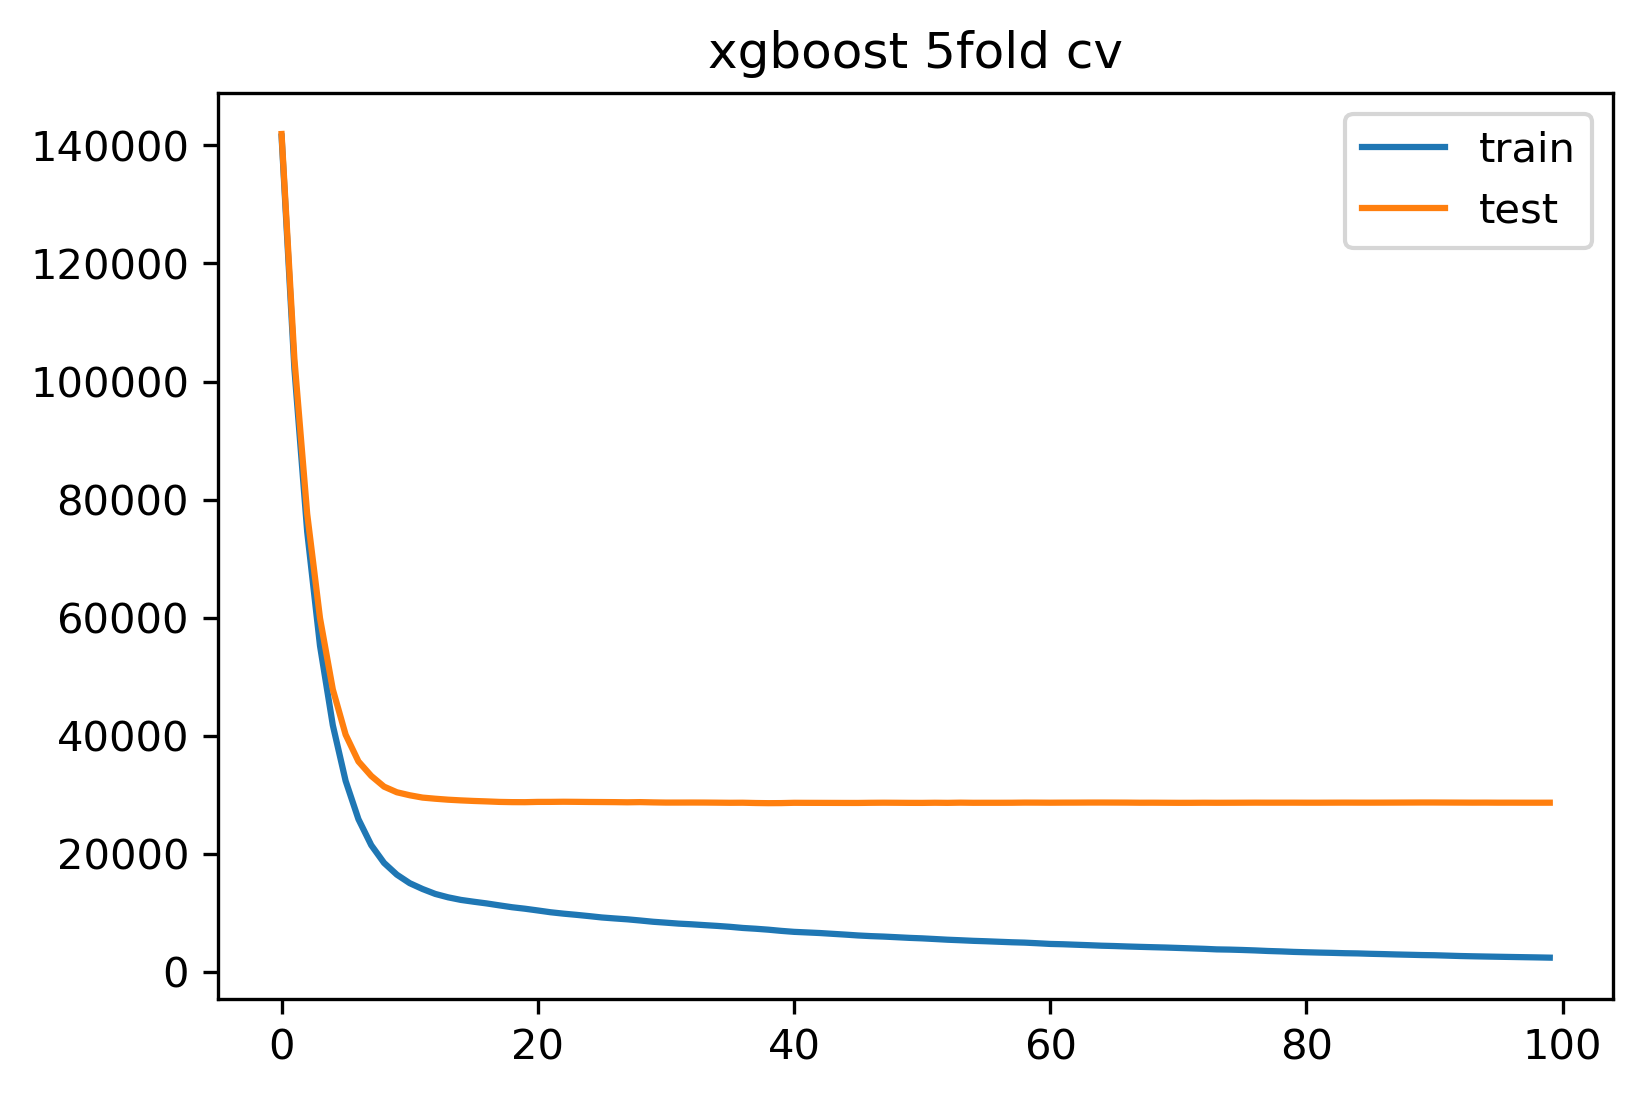

In [ ]:
plt.figure(dpi=300)
plt.plot(result["train-rmse-mean"])
plt.plot(result["test-rmse-mean"])
plt.legend(["train","test"])
plt.title("xgboost 5fold cv");

## 4 XGBoost分类的代码实现

XGBoost默认会实现回归算法，因此在执行分类的时候，我们需要主动声明算法的类型。xgboost是通过当前算法所使用的损失函数来判断任务类型的，即是通过在params中填写的`objective`参数来判断任务类型。当不再执行回归任务时，模型的评估指标也会发生变化，因此xgboost分类所需要的参数会更多。`objective`参数中可以输入数十种不同的选项，常见的有：

- 用于回归
> - **reg:squarederror**：平方损失，即$\frac{1}{2}(y - \hat{y})^2$，其中1/2是为了计算简便<br><br>
> - **reg:squaredlogerror**：平方对数损失，即$\frac{1}{2}[log(\hat{y} + 1) - log(y + 1)]^2$，其中1/2是为了计算简便

- 用于分类
> - **binary:logistic**：二分类交叉熵损失，使用该损失时`predict`接口输出概率。如果你对该损失不熟悉，你需要学习逻辑回归算法。<br><br>
> - **binary:logitraw**：二分类交叉熵损失，使用该损失时`predict`接输出执行sigmoid变化之前的值<br><br>
> - **multi:softmax**：多分类交叉熵损失，使用该损失时`predict`接口输出具体的类别。如果你对该损失不熟悉，你需要学习AdaBoost与GBDT。<br><br>
> - **multi:softprob**：多分类交叉熵，适用该损失时`predict`接口输出每个样本每个类别下的概率

除此之外，还有众多用于排序算法、计数算法的损失函数。xgboost几乎适用于所有可微的损失函数，不同的损失函数会影响`predict`的输出，但却不会影响交叉验证方法`xgb.cv`的输出。当不填写任何内容时，参数`objective`的默认值为`reg:squarederror`。接下来我们来看看xgboost分类器的实现：

- 导入数据

In [ ]:
#导入2个最简单的分类数据集：乳腺癌数据集与手写数字数据集
from sklearn.datasets import load_breast_cancer, load_digits

#二分类数据
X_binary = load_breast_cancer().data
y_binary = load_breast_cancer().target
data_binary = xgb.DMatrix(X_binary,y_binary)

#多分类数据
X_multi = load_digits().data
y_multi = load_digits().target
data_multi = xgb.DMatrix(X_multi, y_multi)

- 设置params，进行训练

相比起默认的回归算法，xgboost分类算法所需的参数会更多一些。二分类损失函数一般需要搭配参数`eval_matric`，用于设置分类的评估指标。xgboost中默认的二分类指标是对数损失（也就是交叉熵损失`logloss`），在更老的版本中，xgboost中默认的二分类指标是错误率`error`，在某些xgboost版本当中，不设置参数`eval_matric`将引发警告。

In [ ]:
params1 = {"seed":1412, "objective":"binary:logistic"
           ,"eval_metric":"logloss" #二分类交叉熵损失
          }
clf_binary = xgb.train(params1, data_binary, num_boost_round=100)

对多分类算法来说，除了设置损失函数和评估指标，还需要设置参数`num_class`。参数`num_class`用于多分类状况下、具体的标签类别数量，例如，如果是三分类，则需设置{"num_calss":3}。通常来说，算法应该能够根据标签的情况自主判断实际类别为多少，但不知为何，在xgboost原生代码及sklearn API当中，部分版本的xgboost都存在无法判断标签类别数量的问题。为避免报错，建议在执行多分类时写上该参数。

In [ ]:
params2 = {"seed":1412, "objective":"multi:softmax"
           ,"eval_metric":"mlogloss" #多分类交叉熵损失 #"merror"
           ,"num_class":10}
clf_multi = xgb.train(params2, data_multi, num_boost_round=100)

- 预测与评估

In [ ]:
y_pred_binary = clf_binary.predict(data_binary)
y_pred_multi = clf_multi.predict(data_multi)

In [ ]:
y_pred_binary[:20] #二分类直接返回概率，不返回类别，需要自己转换

array([5.8410629e-03, 5.9211289e-04, 1.5155278e-04, 2.4505438e-02,
       8.6602634e-03, 2.3524903e-02, 8.7698136e-05, 2.2055734e-04,
       1.5081177e-03, 4.2824438e-03, 1.5698196e-02, 2.2565569e-04,
       4.6376034e-04, 9.0418644e-03, 7.7753547e-03, 6.4944592e-04,
       9.2663817e-05, 1.2998856e-04, 9.4483788e-05, 9.9722409e-01],
      dtype=float32)

In [ ]:
y_pred_multi #多分类，选择`multi:softmax`时返回具体类别，也可以选择`multi:softprob`返回概率。

array([0., 1., 2., ..., 8., 9., 8.], dtype=float32)

In [ ]:
from sklearn.metrics import accuracy_score as ACC #当返回具体类别时，可以使用准确率
from sklearn.metrics import log_loss as logloss #当返回概率时，则必须使用交叉熵损失

In [ ]:
(y_pred_binary > 0.5).astype("int")

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [ ]:
ACC(y_binary,(y_pred_binary > 0.5).astype(int)) #对二分类计算准确率，则必须先转换为类别

1.0

In [ ]:
ACC(y_multi, y_pred_multi)

1.0

两个数据都非常简单，对于xgboost来说都学习到了100%的准确率。来看交叉熵损失：

In [ ]:
logloss(y_binary,y_pred_binary) #只有二分类输出了概率，因此可以查看交叉熵损失

0.004539324697500797

- 交叉验证

分类算法与回归算法执行交叉验证的流程基本一致，但需要注意的是，当使用`xgb.train`时，我们会将评估指标参数`eval_matric`写在params中，在使用`xgb.cv`时，我们却需要将评估指标参数写在`xgb.cv`当中，否则有时候会报出警告。这是一个奇怪的bug，可能会随着xgboost库的迭代更新而消失。如果不介意警告，可以继续将评估指标写在params里的`eval_matric`参数下。在`xgb.cv`当中，我们需要将评估指标打包成元组，写在参数`metrics`内部，如下所示：

In [ ]:
params2 = {"seed":1412
           , "objective":"multi:softmax" #无论填写什么损失函数都不影响交叉验证的评估指标
           , "num_class":10}
result = xgb.cv(params2,data_multi,num_boost_round=100
                ,metrics = ("mlogloss") #交叉验证的评估指标由cv中的参数metrics决定
                ,nfold=5 #补充交叉验证中所需的参数，nfold=5表示5折交叉验证
                ,seed=1412 #交叉验证的随机数种子，params中的是管理boosting过程的随机数种子
               )

In [ ]:
result #返回多分类交叉熵损失

,train-mlogloss-mean,train-mlogloss-std,test-mlogloss-mean,test-mlogloss-std
0,1.228912,0.006192,1.330349,0.039377
1,0.869281,0.005974,1.009304,0.046665
2,0.642709,0.005521,0.805701,0.050207
3,0.484223,0.004590,0.658486,0.049434
4,0.370331,0.004205,0.552657,0.049002
...,...,...,...,...
95,0.003921,0.000027,0.118105,0.027968
96,0.003908,0.000026,0.118007,0.027899
97,0.003896,0.000026,0.118073,0.027942
98,0.003885,0.000026,0.117976,0.027911


参数`metrics`支持多个评估指标：

In [ ]:
params3 = {"seed":1412
           , "objective":"multi:softmax" #无论填写什么损失函数都不影响交叉验证的评估指标
           , "num_class":10}
result = xgb.cv(params3,data_multi,num_boost_round=100
                ,metrics = ("mlogloss","merror")
                ,nfold=5 #补充交叉验证中所需的参数，nfold=5表示5折交叉验证
                ,seed=1412 #交叉验证的随机数种子，params中的是管理boosting过程的随机数种子
               )

In [ ]:
result #可以执行多个指标，让输出结果的列数翻倍

,train-mlogloss-mean,train-mlogloss-std,train-merror-mean,train-merror-std,test-mlogloss-mean,test-mlogloss-std,test-merror-mean,test-merror-std
0,1.228912,0.006192,0.030746,0.002658,1.330349,0.039377,0.122978,0.022670
1,0.869281,0.005974,0.014329,0.003948,1.009304,0.046665,0.094041,0.022593
2,0.642709,0.005521,0.008765,0.002732,0.805701,0.050207,0.080682,0.022009
3,0.484223,0.004590,0.005147,0.001432,0.658486,0.049434,0.070664,0.022264
4,0.370331,0.004205,0.003200,0.001362,0.552657,0.049002,0.065101,0.018976
...,...,...,...,...,...,...,...,...
95,0.003921,0.000027,0.000000,0.000000,0.118105,0.027968,0.038392,0.005910
96,0.003908,0.000026,0.000000,0.000000,0.118007,0.027899,0.038392,0.005910
97,0.003896,0.000026,0.000000,0.000000,0.118073,0.027942,0.038392,0.005910
98,0.003885,0.000026,0.000000,0.000000,0.117976,0.027911,0.038392,0.005910


- sklearn API的实现

In [ ]:
from xgboost import XGBClassifier

由于在sklearn API当中，我们明确了正在执行的任务是分类，因此无需再使用损失函数来帮助我们辨别分类的类型了。然而如果是多分类，建议还是在参数中明确所使用的损失函数：

In [ ]:
clf = XGBClassifier()

In [ ]:
clf.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
clf = XGBClassifier(objective="multi:softmax"
                    , eval_metric="mlogloss" #设置评估指标避免警告
                    , num_class = 10
                  #  , use_label_encoder=False
                   ) 

In [ ]:
clf = clf.fit(X_multi,y_multi)

In [ ]:
clf.predict(X_multi) #输出具体数值 - 具体的预测类别

array([0, 1, 2, ..., 8, 9, 8])

In [ ]:
clf.predict_proba(X_multi).shape #输出概率值

(1797, 10)

In [ ]:
clf.score(X_multi,y_multi) #虽然设置了评估指标，但score接口还是准确率

1.0

到这里，你已经基本掌握了xgboost建模的代码。如果你没有提升模型的需求，只需要跑通代码结果，那这部分内容就足够你使用了。

# 三 XGBoost的参数空间与超参数优化
## 1 确定XGBoost优化的参数空间

丰富的超参数为集成算法提供了无限的可能，以降低偏差为目的的Boosting算法们在调参之后的表现更是所向披靡，因此XGBoost的超参数自动优化也是一个重要的课题。在过去的课程当中我们已经讲解过大量关于树模型参数影响力的内容，因此**在阅读本章之前，强烈建议学习GBDT课程当中超参数空间相关的内容**。属于GBDT的参数空间会极大程度地帮助你理解XGBoost的参数空间。

对任意集成算法进行超参数优化之前，我们需要明确两个基本事实：

1、不同参数对算法结果的影响力大小<br>
2、确定用于搜索的参数空间<br>

对XGBoost来说，我们可以大致如下排列各个参数对算法的影响：

|影响力|参数|
|:-:|:-:|
|⭐⭐⭐⭐⭐<br>几乎总是具有巨大影响力|num_boost_round（整体学习能力）<br>eta（整体学习速率）<br>|
|⭐⭐⭐⭐<br>大部分时候具有影响力|booster（整体学习能力）<br>colsample_by*（随机性）<br>gamma（结构风险 + 精剪枝）<br>lambda（结构风险 + 间接剪枝）<br> min_child_weight（精剪枝）|
|⭐⭐<br>可能有大影响力<br>大部分时候影响力不明显|max_depth（粗剪枝）<br>alpha（结构风险 + 精剪枝）<br>subsamples（随机性）<br>objective（整体学习能力）<br>scale_pos_weight（样本不均衡）|
|⭐<br>当数据量足够大时，几乎无影响|seed<br>base_score（初始化）<br>|

比起其他树的集成算法，XGBoost有大量通过影响建树过程而影响整体模型的参数（比如`gamma`，`lambda`等）。这些参数以较为复杂的方式共同作用、影响模型的最终结果，因此他们的影响力不是线性的，也不总是能在调参过程中明显地展露出来，但调节这些参数大多数时候都能对模型有影响，因此大部分与结构风险相关的参数都被评为4星参数了。相对的，对XGBoost来说总是具有巨大影响力的参数就只有迭代次数与学习率了。

在上述影响力排名当中，需要特别说明以下几点：

1. 在随机森林中影响力巨大的`max_depth`在XGBoost中默认值为6，比GBDT中的调参空间略大，但还是没有太多的空间，因此影响力不足。

2. 在GBDT中影响力巨大的`max_features`对标XGBoost中的`colsample_by*`系列参数，原则上来说影响力应该非常大，但由于三个参数共同作用，调参难度较高，在只有1个参数作用时效果略逊于`max_features`。

3. 精剪枝参数往往不会对模型有太大的影响，但在XGBoost当中，`min_child_weight`与结构分数的计算略微相关，因此有时候会展现出较大的影响力。故而将这个精剪枝参数设置为4星参数。

4. 类似于`objective`这样影响整体学习能力的参数一般都有较大的影响力，但XGBoost当中每种任务可选的损失函数不多，因此一般损失函数不在调参范围之内，故认为该参数的影响力不明显。

5. XGBoost的初始化分数只能是数字，因此当迭代次数足够多、数据量足够大时，起点的影响会越来越小。因此我们一般不会对base_score进行调参。

那在调参的时候，我们应该选择哪些参数呢？与其他树模型一样，我们首先会考虑所有影响力巨大的参数（5星参数），当算力足够/优化算法运行较快的时候，我们可以考虑将大部分时候具有影响力的参数（4星）也都加入参数空间。一般来说，只要样本量足够，我们还是愿意尝试`subsample`以及`max_depth`，如果算力充足，我们还可以加入`obejctive`这样或许会有效的参数。

需要说明的是，一般不会同时使用三个`colsample_by*`参数、更不会同时调试三个`colsample_by*`参数。首先，参数`colsample_bylevel`较为不稳定，不容易把握，因此当训练资源充足时，会同时调整`colsample_bytree`和`colsample_bynode`。如果计算资源不足，或者优先考虑节约计算时间，则会先选择其中一个参数、尝试将特征量控制在一定范围内来建树，并观察模型的结果。在这三个参数中，使用`bynode`在分枝前随机，比使用`bytree`建树前随机更能带来多样性、更能对抗过拟合，但同时也可能严重地伤害模型的学习能力。在这里，我将尝试同时使用两个参数进行调参。

在这样的基本思想下，再结合硬件与运行时间因素，我将选择如下参数进行调整，并使用基于TPE贝叶斯优化（HyperOpt）对XGBoost进行优化——

|参数|
|:-:|
|`num_boost_round`|
|`eta`|
|`booster`|
|`colsample_bynode`|
|`colsample_bytree`|
|`gamma`|
|`lambda`|
|`min_child_weight`|
|`max_depth`|
|`subsamples`|
|`objective`|

在此基础上，我们需要进一步确认参数空间：

- 对于有界的参数（比如`colsample_bynode`，`subsamples`等），或者有固定选项的参数（比如`booster`,`objective`），无需确认参数空间。<br><br>
- 对取值较小的参数（例如学习率`eta`，一般树模型的`min_impurity_decrease`等），或者通常会向下调整的参数（比如`max_depth`），一般是围绕默认值向两边展开构建参数空间。<br><br>
- 对于取值可大可小，且原则上可取到无穷值的参数（`num_boost_round`，`gamma`、`lambda`、`min_child_weight`等），一般需要绘制学习曲线进行提前探索，或者**也可以设置广而稀的参数空间，来一步步缩小范围**。

在之前的课程当中，我们已经对`gamma`和`lambda`的范围进行过探索，其中`lambda`范围[1,2]之间对模型有影响，而`gamma`在[1e6,1e7]之间才对模型有影响。因此我们可以先规定`lambda`的参数空间为np.arange(0,3,0.2)，并规定`gamma`的参数空间为np.arange(1e6,1e7,1e6)。现在我们对剩下2个参数绘制学习曲线进行轻度探索。如下所示：

In [ ]:
import xgboost as xgb
data_xgb = xgb.DMatrix(X,y)

#定义一个函数，用来检测模型迭代完毕后的过拟合情况
def overfitcheck(result):
    return (result.iloc[-1,2] - result.iloc[-1,0]).min()

- **num_boost_round**

一般迭代次数默认为100次，因此我们通常会主动在300或者500以内进行尝试：

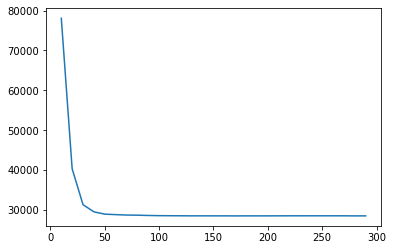

In [ ]:
train = []
test = []
option = np.arange(10,300,10)
overfit = []
for i in option:
    params = {"max_depth":5,"seed":1412,"eta":0.1, "nthread":16
             }
    result = xgb.cv(params,data_xgb,num_boost_round=i
                ,nfold=5 #补充交叉验证中所需的参数，nfold=5表示5折交叉验证
                ,seed=1412 #交叉验证的随机数种子，params中的是管理boosting过程的随机数种子
               )
    overfit.append(overfitcheck(result))
    train.append(result.iloc[-1,0])
    test.append(result.iloc[-1,2])
plt.plot(option,test);

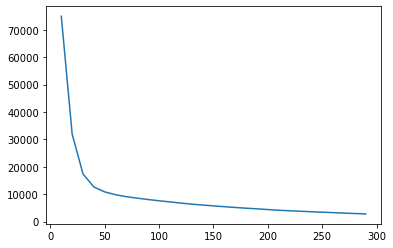

In [ ]:
plt.plot(option,train);

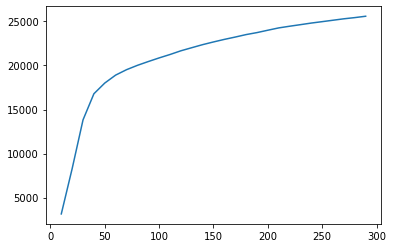

In [ ]:
plt.plot(option,overfit);

可以看到，`num_boost_round`大约增长到50左右就不再对模型有显著影响了，我们可以进一步来查看分数到30000以下之后的情况：

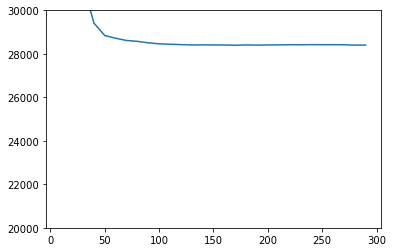

In [ ]:
plt.plot(option,test)
plt.ylim(20000,30000);

100棵树之后损失几乎没有再下降，因此`num_boost_round`的范围可以定到range(50,200,10)。

- **min_child_weight**

作为$h_i$值之和，`min_child_weight`的真实值是可以计算出来的，但精确的计算需要跟随xgboost建树的过程运行，因此比较麻烦。遗憾的是，xgboost官方并未提供调用树结构以及$h_i$值的接口，因此最佳方案其实是对每个叶子上的样本量进行估计。

In [ ]:
X.shape

(1460, 80)

现在总共有样本1460个，在五折交叉验证中训练集共有1460\*0.8 = 1168个样本。由于CART树是二叉树，我们规定的最大深度为5，因此最多有$2^5 = 32$个叶子节点，平均每个叶子结点上的样本量大概为1168/32 = 36.5个。粗略估计，如果`min_child_weight`是一个小于36.5的值，就可能对模型造成巨大影响。当然，不排除有大量样本集中在一片叶子上的情况，因此我们可以设置备选范围稍微放大，例如设置为[0,100]来观察模型的结果。

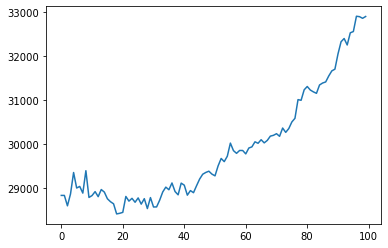

In [ ]:
train = []
test = []
option = np.arange(0,100,1)
overfit = []
for i in option:
    params = {"max_depth":5,"seed":1412,"eta":0.1, "nthread":16
              ,"min_child_weight":i
             }
    result = xgb.cv(params,data_xgb,num_boost_round=50
                ,nfold=5 #补充交叉验证中所需的参数，nfold=5表示5折交叉验证
                ,seed=1412 #交叉验证的随机数种子，params中的是管理boosting过程的随机数种子
               )
    overfit.append(overfitcheck(result))
    train.append(result.iloc[-1,0])
    test.append(result.iloc[-1,2])
plt.plot(option,test);

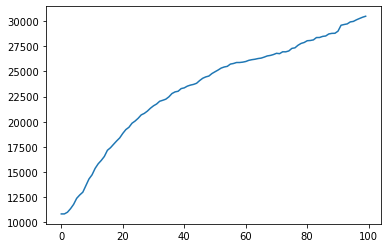

In [ ]:
plt.plot(option,train);

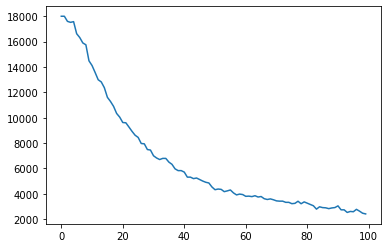

In [ ]:
plt.plot(option,overfit);

很明显，`min_child_weight`在0~40的范围之内对测试集上的交叉验证损失有较好的抑制作用，因此我们可以将`min_child_weight`的调参空间设置为range(0,50,2)来进行调参。

如此，全部参数的参数空间就确定了，如下所示：

|参数|范围|
|:-:|:-:|
|`num_boost_round`|学习曲线探索，最后定为<br>(50,200,10)|
|`eta`|以0.3为中心向两边延展，最后定为<br>(0.05,2.05,0.05)|
|`booster`|两种选项<br>["gbtree","dart"]|
|`colsample_bytree`|设置为(0,1]之间的值，但由于还有参数`bynode`，因此整体不宜定得太小，因此定为<br>(0.3,1,0.1)|
|`colsample_bynode`|设置为(0,1]之间的值，定为<br>(0.1,1,0.1)|
|`gamma`|学习曲线探索，有较大可能需要改变，定为<br>(1e6,1e7,1e6)|
|`lambda`|学习曲线探索，定为<br>(0,3,0.2)|
|`min_child_weight`|学习曲线探索，定为<br>(0,50,2)|
|`max_depth`|以6为中心向两边延展，右侧范围定得更大<br>(2,30,2)|
|`subsample`|设置为(0,1]之间的值，定为<br>(0.1,1,0.1)|
|`objective`|两种回归类模型的评估指标<br>["reg:squarederror", "reg:squaredlogerror"]|
|`rate_drop`|如果选择"dart"树所需要补充的参数，设置为(0,1]之间的值<br>(0.1,1,0.1)|

一般在初次搜索时，我们会设置范围较大、较为稀疏的参数空间，然后在多次搜索中逐渐缩小范围、降低参数空间的维度。不过这一次设置的参数空间都较为密集，参数也较多，大家在实际进行设置的时候可以选择与我设置的不同的范围或密度。

## 2 基于TEP对XGBoost进行优化

In [ ]:
#日常使用库与算法
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mlp
import matplotlib.pyplot as plt
import time
import xgboost as xgb

#导入优化算法
import hyperopt
from hyperopt import hp, fmin, tpe, Trials, partial
from hyperopt.early_stop import no_progress_loss

In [ ]:
data = pd.read_csv(r"D:\myJupyter\机器学习\datasets\House Price\train_encode.csv",index_col=0)

In [ ]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [ ]:
X.shape

(1460, 80)

> Step 1.建立benchmark

|算法|RF<br>(TPE)|AdaBoost<br>(TPE)|GBDT<br>(TPE)|
|:-:|:-:|:-:|:-:|
|5折验证<br>运行时间|0.22s|0.27s|<font color="brown">**1.54s(↑)**</font>|
|测试最优分数<br>(RMSE)|28346.673|35169.730|<font color="green">**26415.835(↓)**</font>|

> Step 2.定义目标函数、参数空间、优化函数、验证函数
>> 目标函数

In [ ]:
def hyperopt_objective(params):
    paramsforxgb = {"eta":params["eta"]
                    ,"booster":params["booster"]
                    ,"colsample_bytree":params["colsample_bytree"]
                    ,"colsample_bynode":params["colsample_bynode"]
                    ,"gamma":params["gamma"]
                    ,"lambda":params["lambda"]
                    ,"min_child_weight":params["min_child_weight"]
                    ,"max_depth":int(params["max_depth"])
                    ,"subsample":params["subsample"]
                    ,"objective":params["objective"]
                    ,"rate_drop":params["rate_drop"]
                    ,"nthread":14
                    ,"verbosity":0
                    ,"seed":1412}
    result = xgb.cv(params,data_xgb, seed=1412, metrics=("rmse")
                    ,num_boost_round=int(params["num_boost_round"]))
    return result.iloc[-1,2]

>> 参数空间

In [ ]:
param_grid_simple = {'num_boost_round': hp.quniform("num_boost_round",50,200,10)
                     ,"eta": hp.quniform("eta",0.05,2.05,0.05)
                     ,"booster":hp.choice("booster",["gbtree","dart"])
                     ,"colsample_bytree":hp.quniform("colsample_bytree",0.3,1,0.1)
                     ,"colsample_bynode":hp.quniform("colsample_bynode",0.1,1,0.1)
                     ,"gamma":hp.quniform("gamma",1e6,1e7,1e6)
                     ,"lambda":hp.quniform("lambda",0,3,0.2)
                     ,"min_child_weight":hp.quniform("min_child_weight",0,50,2)
                     ,"max_depth":hp.choice("max_depth",[*range(2,30,2)])
                     ,"subsample":hp.quniform("subsample",0.1,1,0.1)
                     ,"objective":hp.choice("objective",["reg:squarederror","reg:squaredlogerror"])
                     ,"rate_drop":hp.quniform("rate_drop",0.1,1,0.1)
                    }

>> 优化函数

In [ ]:
def param_hyperopt(max_evals=100):
    
    #保存迭代过程
    trials = Trials()
    
    #设置提前停止
    early_stop_fn = no_progress_loss(30)
    
    #定义代理模型
    params_best = fmin(hyperopt_objective
                       , space = param_grid_simple
                       , algo = tpe.suggest
                       , max_evals = max_evals
                       , verbose=True
                       , trials = trials
                       , early_stop_fn = early_stop_fn
                      )
    
    #打印最优参数，fmin会自动打印最佳分数
    print("\n","\n","best params: ", params_best,
          "\n")
    return params_best, trials

> Step 3.训练贝叶斯优化器

XGBoost中涉及到前所未有多的随机性，因此模型可能表现得极度不稳定，我们需要多尝试几次贝叶斯优化来观察模型的稳定性。因此在这里我们完成了5次贝叶斯优化，查看如下的结果：

In [ ]:
params_best, trials = param_hyperopt(100) #由于参数空间巨大，给与100次迭代的空间

 38%|██████████████████▏                             | 38/100 [05:16<08:36,  8.33s/trial, best loss: 26753.27408833333]

 
 best params:  {'booster': 1, 'colsample_bynode': 0.8, 'colsample_bytree': 0.8, 'eta': 1.55, 'gamma': 2000000.0, 'lambda': 0.2, 'max_depth': 2, 'min_child_weight': 0.0, 'num_boost_round': 200.0, 'objective': 0, 'rate_drop': 0.2, 'subsample': 0.9} 



在迭代的早期就因提前停止而停下了，修改提前停止的容忍次数为30次，继续尝试：

In [ ]:
params_best, trials = param_hyperopt(100)

 57%|██████████████████████████▊                    | 57/100 [05:43<04:18,  6.02s/trial, best loss: 26775.553385333333]

 
 best params:  {'booster': 1, 'colsample_bynode': 0.5, 'colsample_bytree': 1.0, 'eta': 0.5, 'gamma': 10000000.0, 'lambda': 1.6, 'max_depth': 2, 'min_child_weight': 0.0, 'num_boost_round': 110.0, 'objective': 0, 'rate_drop': 0.1, 'subsample': 0.7000000000000001} 



In [ ]:
params_best, trials = param_hyperopt(100)

 41%|███████████████████▎                           | 41/100 [02:07<03:03,  3.11s/trial, best loss: 27363.138020666665]

 
 best params:  {'booster': 0, 'colsample_bynode': 1.0, 'colsample_bytree': 0.5, 'eta': 0.05, 'gamma': 7000000.0, 'lambda': 2.4000000000000004, 'max_depth': 9, 'min_child_weight': 0.0, 'num_boost_round': 170.0, 'objective': 0, 'rate_drop': 0.7000000000000001, 'subsample': 0.6000000000000001} 



In [ ]:
params_best, trials = param_hyperopt(100)

 52%|████████████████████████▍                      | 52/100 [05:26<05:01,  6.29s/trial, best loss: 27745.835937666667]

 
 best params:  {'booster': 1, 'colsample_bynode': 0.30000000000000004, 'colsample_bytree': 1.0, 'eta': 2.0, 'gamma': 7000000.0, 'lambda': 0.0, 'max_depth': 8, 'min_child_weight': 2.0, 'num_boost_round': 110.0, 'objective': 0, 'rate_drop': 0.4, 'subsample': 0.7000000000000001} 



In [ ]:
params_best, trials = param_hyperopt(100)

 32%|███████████████                                | 32/100 [05:21<11:23, 10.05s/trial, best loss: 26803.143880333333]

 
 best params:  {'booster': 1, 'colsample_bynode': 0.9, 'colsample_bytree': 0.4, 'eta': 1.3, 'gamma': 9000000.0, 'lambda': 1.2000000000000002, 'max_depth': 8, 'min_child_weight': 4.0, 'num_boost_round': 180.0, 'objective': 0, 'rate_drop': 0.1, 'subsample': 1.0} 



这个结果差强人意，比起GBDT跑出的最佳分数还有距离，但我们可以在此基础上继续调整参数空间。以下是5次调参的结果总结：

||1|2|3|4|5|
|:-:|:-:|:-:|:-:|:-:|:-:|
|num_boost_round|200|110|170|110|180|
|booster|1|1|0|1|1|
|objective|0|0|0|0|0|
|colsample_bynode|0.8|0.5|1.0|0.3|0.9|
|colsample_bytree|0.8|1.0|0.5|1.0|0.4|
|eta|1.55|0.5|0.05|1.0|1.3|
|gamma|2e6|1e7|7e6|7e6|9e6|
|lambda|0.2|1.6|2.4|0|1.2|
|max_depth|2|2|9|8|8|
|min_child_weight|0|0|0|2|4|
|rate_drop|0.2|0.7|0.7|0.4|0.1|
|subsample|0.9|0.7|0.6|0.7|1|

首先，`objective`在所有迭代中都被选为"reg:squarederror"，这也是xgboost的默认值，因此不再对该参数进行搜索。同样的。`booster`参数在5次运行中有4次被选为"dart"，因此基本可以确认对目前的数据使用DART树是更好的选择。同时在参考结果时我们就可以不太考虑第三次搜索的结果，因为第三次搜索是给予普通gbtree给出的结果。

对于其他参数，我们则根据搜索结果**修改空间范围、增加空间密度**，一般让范围向选中更多的一边倾斜，并且减小步长。例如`num_boost_round`从来没有选到100以下的值，还有一次触顶，两次接近上限，因此可以将原本的范围(50,200,10)修改为(100,300,10)。`colsample_bynode`的结果均匀地分布在0.3~1之间，可以考虑不更换范围，但缩小步长。`colsample_bytree`的结果更多偏向于1.0，因此可以考虑提升下限。其他的参数也以此类推：

In [ ]:
param_grid_simple = {'num_boost_round': hp.quniform("num_boost_round",100,300,10)
                     ,"eta": hp.quniform("eta",0.05,2.05,0.05)
                     ,"colsample_bytree":hp.quniform("colsample_bytree",0.5,1,0.05)
                     ,"colsample_bynode":hp.quniform("colsample_bynode",0.3,1,0.05)
                     ,"gamma":hp.quniform("gamma",5e6,1.5e7,5e5)
                     ,"lambda":hp.quniform("lambda",0,2,0.1)
                     ,"min_child_weight":hp.quniform("min_child_weight",0,10,0.5)
                     ,"max_depth":hp.choice("max_depth",[*range(2,15,1)])
                     ,"subsample":hp.quniform("subsample",0.5,1,0.05)
                     ,"rate_drop":hp.quniform("rate_drop",0.1,1,0.05)
                    }

In [ ]:
def hyperopt_objective(params):
    paramsforxgb = {"eta":params["eta"]
                    ,"colsample_bytree":params["colsample_bytree"]
                    ,"colsample_bynode":params["colsample_bynode"]
                    ,"gamma":params["gamma"]
                    ,"lambda":params["lambda"]
                    ,"min_child_weight":params["min_child_weight"]
                    ,"max_depth":int(params["max_depth"])
                    ,"subsample":params["subsample"]
                    ,"rate_drop":params["rate_drop"]
                    ,"booster":"dart"
                    ,"nthred":14
                    ,"verbosity":0
                    ,"seed":1412}
    result = xgb.cv(params,data_xgb, seed=1412, metrics=("rmse")
                    ,num_boost_round=int(params["num_boost_round"]))
    return result.iloc[-1,2]

> Step 4.在修改后的参数空间上，继续训练贝叶斯优化器

In [ ]:
params_best, trials = param_hyperopt(100) #提前停止的容忍次数提高为50次

 29%|█████████████▉                                  | 29/100 [00:53<02:00,  1.69s/trial, best loss: 27279.83528666667]

D:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



100%|██████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/trial, best loss: 25662.024739666667]

 
 best params:  {'colsample_bynode': 0.45, 'colsample_bytree': 1.0, 'eta': 0.05, 'gamma': 13000000.0, 'lambda': 0.5, 'max_depth': 6, 'min_child_weight': 0.5, 'num_boost_round': 150.0, 'rate_drop': 0.65, 'subsample': 0.8500000000000001} 



In [ ]:
params_best, trials = param_hyperopt(100)

100%|██████████████████████████████████████████████| 100/100 [02:38<00:00,  1.59s/trial, best loss: 25711.822916666668]

 
 best params:  {'colsample_bynode': 0.7000000000000001, 'colsample_bytree': 0.75, 'eta': 0.1, 'gamma': 13500000.0, 'lambda': 1.8, 'max_depth': 3, 'min_child_weight': 1.5, 'num_boost_round': 210.0, 'rate_drop': 0.7000000000000001, 'subsample': 1.0} 



In [ ]:
params_best, trials = param_hyperopt(100)

 58%|███████████████████████████▎                   | 58/100 [01:33<01:07,  1.62s/trial, best loss: 25737.109375333337]

 
 best params:  {'colsample_bynode': 0.7000000000000001, 'colsample_bytree': 0.9500000000000001, 'eta': 0.05, 'gamma': 8000000.0, 'lambda': 0.8, 'max_depth': 9, 'min_child_weight': 1.0, 'num_boost_round': 160.0, 'rate_drop': 0.30000000000000004, 'subsample': 0.8} 



In [ ]:
params_best, trials = param_hyperopt(100)

 33%|███████████████▌                               | 33/100 [01:01<02:04,  1.85s/trial, best loss: 26307.809244666667]

 
 best params:  {'colsample_bynode': 0.7000000000000001, 'colsample_bytree': 0.7000000000000001, 'eta': 0.05, 'gamma': 8000000.0, 'lambda': 1.8, 'max_depth': 3, 'min_child_weight': 1.5, 'num_boost_round': 270.0, 'rate_drop': 0.6000000000000001, 'subsample': 0.8500000000000001} 



In [ ]:
params_best, trials = param_hyperopt(100)

100%|████████████████████████████████████████████████████| 100/100 [02:49<00:00,  1.69s/trial, best loss: 26049.842448]

 
 best params:  {'colsample_bynode': 0.5, 'colsample_bytree': 0.65, 'eta': 0.05, 'gamma': 12500000.0, 'lambda': 0.2, 'max_depth': 4, 'min_child_weight': 1.0, 'num_boost_round': 220.0, 'rate_drop': 0.5, 'subsample': 0.55} 



我们在经过调整后的参数空间上进行了5次搜索，其中得到的最糟糕的成绩是26307.809，但这已经是一个超越GBDT的分数。在5次搜索当中，我们得到的最佳分数是25662.024。现在我们可以尝试在验证函数上验证这一组参数：

> Step 5.验证参数
>> 验证函数

In [ ]:
def hyperopt_validation(params):
    paramsforxgb = {"eta":params["eta"]
                    ,"booster":"dart"
                    ,"colsample_bytree":params["colsample_bytree"]
                    ,"colsample_bynode":params["colsample_bynode"]
                    ,"gamma":params["gamma"]
                    ,"lambda":params["lambda"]
                    ,"min_child_weight":params["min_child_weight"]
                    ,"max_depth":int(params["max_depth"])
                    ,"subsample":params["subsample"]
                    ,"rate_drop":params["rate_drop"]
                    ,"nthred":14
                    ,"verbosity":0
                    ,"seed":1412}
    result = xgb.cv(params,data_xgb, seed=1412, metrics=("rmse")
                    ,num_boost_round=int(params["num_boost_round"]))
    return result.iloc[-1,2]

In [ ]:
bestparams = {'colsample_bynode': 0.45
               , 'colsample_bytree': 1.0
               , 'eta': 0.05
               , 'gamma': 13000000.0
               , 'lambda': 0.5
               , 'max_depth': 6
               , 'min_child_weight': 0.5
               , 'num_boost_round': 150.0
               , 'rate_drop': 0.65
               , 'subsample': 0.8500000000000001} 

In [ ]:
start = time.time()
hyperopt_validation(bestparams)

25368.487630333333

In [ ]:
end = (time.time() - start)
print(end)

1.1478571891784668


|算法|RF<br>(TPE)|AdaBoost<br>(TPE)|GBDT<br>(TPE)|XGB<br>(TPE)|
|:-:|:-:|:-:|:-:|:-:|
|5折验证<br>运行时间|0.22s|0.27s|1.54s(↑)|<font color="green">**1.14s(↓)**</font>|
|测试最优分数<br>(RMSE)|28346.673|35169.730|26415.835(↓)|<font color="green">**25368.487(↓)**</font>|

从参数的密度来看，我们还可以继续提升我们的分数，但课时有限，我们就不再继续调整了，大家可以顺着相似的思路继续往下调整，查看XGBoost是否还有更大的空间。